# Cropped classification dataset parser

This parser extracts cropped samples of every individual present in every frame and writes out its respective class into the file name and a text file containing relative file pathsand classes. Therefore, the number of samples exported by this parser is equal to the number of generated samples times the number of visible specimens in each image.


<table><tr>
<td> <img src=../example_data/CLASSIFICATION/input-multi_00_id_4_synth_class_Atta_vollenweideri_00501.png width="128"/> </td>
<td> <img src=../example_data/CLASSIFICATION/input-multi_01_id_2_synth_class_Leptoglossus_zonatus.png width="128"/> </td>
<td> <img src=../example_data/CLASSIFICATION/input-multi_03_id_4_synth_class_Atta_vollenweideri_00501.png width="128"/> </td>
<td> <img src=../example_data/CLASSIFICATION/input-multi_08_id_1_synth_class_Gnathamitermes_soldier.png width="128"/> </td>
</tr></table>


### The generated output includes the following annotation data:
* Classes

### Output structure:
* target_dir
    * **img_data.txt** - _containing all relative file paths and class data_
    * **all generated images**
    
### Notes:

* This is an experimental parser for ongoing studies and will likely be revised or removed in future releases

In [1]:
import cv2
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

### Required parameters

Specify the location of your **generated dataset** and in which **output directory** you wish to save it.

**Notes:**
* do not include trailing forward slashes in your paths (see examples below)
* Your **dataset** name should **NOT include underscores** as they are used to separate passes into their categories. Instead, use hyphens in your naming convention where applicable.

In [2]:
# define location of dataset and return all files
dataset_location = "../example_data/input-multi"
target_dir = "../example_data/CLASSIFICATION"

# resize each sub window to a fixed resolution (set to None, if not desired)
resize_resolution = 256

# determine the proportion of a bounding box that needs to be filled before considering the visibility as too low
visibility_threshold = 0.15

### Optional parameters

In [3]:
# set True to show processing results for each image (disables parallel processing)
DEBUG = False

The following lines will load the generated dataset from your drive and prepare it for the multi-threaded parsing process

In [4]:
all_files = [f for f in listdir(dataset_location) if isfile(join(dataset_location, f))]
all_files.sort()

# next, sort files into images, depth maps, segmentation maps, data, and colony info
# we only need the location and name of the data files, as all passes follow the same naming convention
dataset_data = []
dataset_img = []
dataset_ID = []
dataset_depth = []
dataset_norm = []
dataset_colony = None

for file in all_files:
    loc = dataset_location + "/" + file
    file_info = file.split("_")
    
    if file_info[1] == "BatchData":
        dataset_colony = loc
        
    elif len(file_info) == 2:
        # images are available in various formats, but annotation data is always written as json files
        if file_info[-1].split(".")[-1] == "json":
            dataset_data.append(loc)
        else:
            dataset_img.append(loc)
            
    elif file_info[2].split(".")[0] == "ID":
        dataset_ID.append(loc)
    elif file_info[2].split(".")[0]  == "depth":
        dataset_depth.append(loc)
    elif file_info[2].split(".")[0]  == "norm":
        dataset_norm.append(loc)
        
print("Found",len(dataset_data),"samples...")

# next sort the colony info into its IDs to determine the colony size and individual scales
# Opening colony (BatchData) JSON file
colony_file = open(dataset_colony)
 
# returns JSON object as a dictionary
colony = json.load(colony_file)
colony_file.close()


""" !!! requires IDs, model names, scales !!! """

print("\nThe classes of each simulated individual are:")
# get provided classes to create a dictionary of class IDs and class names
subject_classes = {}
for i,sbj in enumerate(colony["Subject Variations"].keys()):
    subject_classes[i] = [colony["Subject Variations"][sbj]["Class"] , colony["Subject Variations"][sbj]["Scale"]]
    print("ID",i,"class",subject_classes[i][0])

print("\nLoaded colony file with seed", colony['Seed'],"and",len(colony["Subject Variations"].keys()),"individuals.")

Found 10 samples...

The classes of each simulated individual are:
ID 0 class Atta_vollenweideri_00491
ID 1 class Gnathamitermes_soldier
ID 2 class Leptoglossus_zonatus
ID 3 class Leptoglossus_zonatus
ID 4 class Atta_vollenweideri_00501
ID 5 class Atta_vollenweideri_00491
ID 6 class Atta_vollenweideri_00222
ID 7 class Atta_vollenweideri_00222
ID 8 class Atta_vollenweideri_00501
ID 9 class Atta_vollenweideri_00491

Loaded colony file with seed 12345 and 10 individuals.


In [5]:
print("Number of loaded samples:",len(dataset_data))
print("Colony size:",len(colony['Subject Variations']))

output_file_names = ["" for i in range(len(dataset_data) * len(colony['Subject Variations']))]

Number of loaded samples: 10
Colony size: 10


With all dataset related parameters configured, we have provided a multi-threaded parsing solution below to minimise the processing time it takes to bring the entire dataset into the required output format. Currently, we instanciate one processing thread per (virtual) CPU core but you can adjust this value if you wish by changing:

```
threadList_export = createThreadList(#NumDesiredThreads)
```

**Note:** To see the process of mask generation from ID passes in action, set the **DEBUG** mode to **"True"**. This will however slow down the processing speed considerably and only run in single-threaded mode!

In [6]:
# create unique colours for each ID
import numpy as np
import time

# alright. Let's take it from the top and fucking multi-thread this.
import threading
import queue
import sys
import os

def fix_bounding_boxes(coords,max_val = [1024,1024]):
    # fix bounding box coordinates so they do not reach beyond the image
    fixed_coords = []
    for c, coord in enumerate(coords):
        if c == 0 or c == 2:
            max_val_temp = max_val[0]
        else:
            max_val_temp = max_val[1]
            
        if coord >= max_val_temp:
            coord = max_val_temp
        elif coord <= 0:
            coord = 0
        
        fixed_coords.append(int(coord))
        
    return fixed_coords

def getThreads():
    """ Returns the number of available threads on a posix/win based system """
    if sys.platform == 'win32':
        return int(os.environ['NUMBER_OF_PROCESSORS'])
    else:
        return int(os.popen('grep -c cores /proc/cpuinfo').read())

class exportThread(threading.Thread):
    def __init__(self, threadID, name, q):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.q = q

    def run(self):
        print("Starting " + self.name)
        process_detections(self.name, self.q)
        print("Exiting " + self.name)
        
def createThreadList(num_threads):
    threadNames = []
    for t in range(num_threads):
        threadNames.append("Thread_" + str(t))

    return threadNames

def process_detections(threadName, q):
    while not exitFlag_export:
        queueLock.acquire()
        if not workQueue_export.empty():
            
            data_input = q.get()
            i, data_loc, img, ID = data_input
            queueLock.release()
            
            display_img = cv2.imread(img)
            display_img_orig = display_img.copy()
            
            # compute visibility for each individual
            seg_img = cv2.imread(ID)
            seg_img_display = seg_img.copy()
            
            data_file = open(data_loc)
            # returns JSON object as a dictionary
            data = json.load(data_file)
            data_file.close()
            
            img_shape = display_img.shape
            
            # only add images that contain visibile individuals
            is_empty = True

            img_info = []
            
            # check if the size of the image and segmentation pass match
            if img_shape != seg_img.shape:
                print("Size mismatch of image and segmentation pass for sample",data_input[1].split("/")[-1],"!")
                incorrectly_formatted_images.append(i)
            else:
                for im, individual in enumerate(data["iterationData"]["subject Data"]):
                    ind_key = list(individual.keys())[0]
                    ind_ID = int(ind_key)
                    class_name = subject_classes[ind_ID - 1][0]
                    # WARNING ID numbering begins at 1
                    
                    img_name = img.split('/')[-1][:-4] + "_id_" + str(im) + "_synth_class_" + class_name +".png"
                    # write the file path to the all_points array
                    fontColor = (int(ID_colours[ind_ID,0]),
                                 int(ID_colours[ind_ID,1]),
                                 int(ID_colours[ind_ID,2]))
                    
                    bbox_orig = [individual[ind_key]["2DBounds"]["xmin"],
                                 individual[ind_key]["2DBounds"]["ymin"],
                                 individual[ind_key]["2DBounds"]["xmax"],
                                 individual[ind_key]["2DBounds"]["ymax"]]
                    
                    bbox = fix_bounding_boxes(bbox_orig, max_val=display_img.shape)
                    
                    # only process an individual if its bounding box width and height are not zero
                    if bbox[2] - bbox[0] == 0 or bbox[3] - bbox[1] == 0:
                        continue

                    try:
                        ID_mask = cv2.inRange(seg_img[bbox[1]:bbox[3],bbox[0]:bbox[2]], np.array([0, 0, ind_ID - 2]), 
                                              np.array([0, 0, ind_ID + 2]))
                        indivual_occupancy = cv2.countNonZero(ID_mask)
                    except:
                        if len(threadList) == 1: 
                            print("Individual fully occluded:",ind_ID,"in",dataset_seg[i])
                        indivual_occupancy = 1

                    #indivual_occupancy = np.count_nonzero((seg_img == [0, 0, int((individual[0]/len(colony['ID']))*255)]).all(axis = 2)) + np.count_nonzero((seg_img == [0, 0, int((individual[0]/len(colony['ID']))*255 - 1)]).all(axis = 2)) + np.count_nonzero((seg_img == [0, 0, int((individual[0]/len(colony['ID']))*255 + 1)]).all(axis = 2))
                    bbox_area = abs((bbox[2] - bbox[0]) * (bbox[3] - bbox[1])) + 1
                    bbox_occupancy = indivual_occupancy / bbox_area
                    bbox_ratio = abs((bbox[2] - bbox[0]) / (bbox[3] - bbox[1]))
                    #print("Individual", individual[0], "with bounding box occupancy ",bbox_occupancy)

                    #cv2.putText(display_img, "ID: " + str(int(individual[0])), (bbox[0] + 10,bbox[3] - 10), font, fontScale, fontColor, lineType)
                    # check that enough of the individual is visible to warrant producing a sample from it 
                    # - high enough visibility
                    # - large enough image patch
                    # - no extreme aspect ratios
                    if bbox_occupancy > visibility_threshold and bbox_area > (resize_resolution**2)/10 and bbox_ratio <= 3 and bbox_ratio >= 0.33:
                        # let's binarise the image and dilate it to make sure all points that visible are found
                        
                        if resize_resolution is not None:
                            display_img_crop = display_img[bbox[1]:bbox[3],bbox[0]:bbox[2]]
                            resized_display_img = cv2.resize(display_img_crop, 
                                                             (resize_resolution, resize_resolution), 
                                                             interpolation = cv2.INTER_CUBIC)
                            cv2.imwrite(target_dir + "/" + img_name, resized_display_img)
                        else:
                            cv2.imwrite(target_dir + "/" + img_name, display_img[bbox[1]:bbox[3],bbox[0]:bbox[2]])

                    else:
                        incorrectly_formatted_images.append(i * len(colony['Subject Variations']) + im)
                        
            
        else:
            queueLock.release()
            
# setup as many threads as there are (virtual) CPU cores
exitFlag_export = 0
# only use a fourth of the number of CPUs for export as hugin and enfuse utilise multi core processing in part
threadList_export = createThreadList(getThreads())
print("Using", len(threadList_export), "threads for export...")
queueLock = threading.Lock()

# define paths to all images and set the maximum number of items in the queue equivalent to the number of images
workQueue_export = queue.Queue(len(dataset_img))
threads = []
threadID = 1

# keep track of all incorrectly formatted images to remove them after iterating over all entries
incorrectly_formatted_images = []

np.random.seed(seed=1)
ID_colours = np.random.randint(255, size=(255, 3))

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
lineType = 2

# remember to define an export folder when saving out your dataset
generate_dataset = True

timer = time.time()

# Create new threads
for tName in threadList_export:
    thread = exportThread(threadID, tName, workQueue_export)
    thread.start()
    threads.append(thread)
    threadID += 1

# Fill the queue with samples
queueLock.acquire()
for i, (data, img, ID) in enumerate(zip(dataset_data , dataset_img, dataset_ID)):
    workQueue_export.put([i, data, img, ID])
queueLock.release()

# Wait for queue to empty
while not workQueue_export.empty():
    pass

# Notify threads it's time to exit
exitFlag_export = 1

# Wait for all threads to complete
for t in threads:
    t.join()
print("Exiting Main export Thread")

# close all windows if they were opened
cv2.destroyAllWindows()

# now, remove all incorrectly formatted imaged from the points and file list
incorrectly_formatted_images.sort()

print("Total time elapsed:",time.time()-timer,"seconds")

Using 12 threads for export...
Starting Thread_0
Starting Thread_1
Starting Thread_2
Starting Thread_3
Starting Thread_4
Starting Thread_5
Starting Thread_6
Starting Thread_7
Starting Thread_8
Starting Thread_9
Starting Thread_10
Starting Thread_11
Exiting Thread_11
Exiting Thread_9
Exiting Thread_10Exiting Thread_3

Exiting Thread_4
Exiting Thread_5
Exiting Thread_7
Exiting Thread_6
Exiting Thread_0
Exiting Thread_8Exiting Thread_2

Exiting Thread_1
Exiting Main export Thread
Total time elapsed: 0.1655576229095459 seconds


Now, write out a single text file, containing the paths to all images and skip over any duplicates so that datasets from heterogenious sources may be combined.

In [7]:
# read all written-out images from the target folder and create a comprehensive label file
all_output_images = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
class_list = []

with open(target_dir + "/img_data.txt", 'w') as f:
    for elem in all_output_images:
        if elem[-3:] != "txt":
            class_elem = elem.split("class_")[1][:-4]
            f.write(elem + "," + class_elem + "\n")
            class_list.append(class_elem)
            

Finally, get some basic stats of the generated dataset regarding class distributions

Class representation:

('Atta_vollenweideri_00222', 3)
('Atta_vollenweideri_00491', 4)
('Atta_vollenweideri_00501', 3)
('Gnathamitermes_soldier', 3)
('Leptoglossus_zonatus', 1)

The dataset includes 5 unique classes


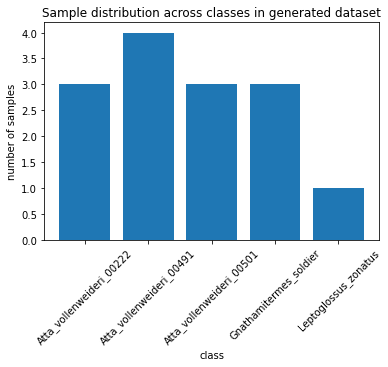

In [8]:
#import Counter
from collections import Counter, OrderedDict

#new list with key-value pairs
class_counter = Counter(class_list)
class_counter_ordered = OrderedDict(sorted(class_counter.items()))

print("Class representation:\n")

for item in class_counter_ordered.items():
    print(item)

#count of unique values
print("\nThe dataset includes", len(Counter(class_counter_ordered)), "unique classes")

plt.bar(class_counter_ordered.keys(), class_counter_ordered.values())
plt.xticks(rotation=45)
plt.ylabel("number of samples")
plt.xlabel("class")
plt.title("Sample distribution across classes in generated dataset")
plt.show()